# <center> Лабораторная работа 7

## <center> _Predict credit default_

### _Автор: Стецук Максим ИВТ 3 курс_

In [1]:
# Игнорирование ошибок
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wget
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn import linear_model, ensemble

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
%%capture
!wget https://www.dropbox.com/s/io67uppgq66plbp/training_data.csv
!wget https://www.dropbox.com/s/2ga9maqxbsf8xhg/test_data.csv

In [4]:
# Чтение и анализ данных
training_data = pd.read_csv('training_data.csv')

training_data.sample(10)

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         40147 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    48667 non-null  float64
dtypes: float64(4), 

In [5]:
training_data.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.250476,65,0,1963.000000,NaN,5,0,2,0,0.0
1,0,0.975402,58,0,0.049441,5905.0,1,0,0,0,0.0
2,0,0.000000,82,0,0.000933,3215.0,10,0,0,0,0.0
3,0,0.571491,36,0,0.113864,2300.0,6,1,0,0,0.0
4,0,0.410499,45,0,0.478572,7816.0,11,0,1,0,1.0
5,0,0.534543,63,0,0.232686,16416.0,11,0,3,0,0.0
6,0,0.982226,52,0,0.804941,3075.0,8,0,2,0,1.0
7,0,0.000000,52,1,0.452927,7583.0,11,0,3,0,0.0
8,0,0.086378,51,0,0.219463,6000.0,5,0,2,0,3.0
9,1,1.000000,50,2,0.128020,5256.0,1,0,0,1,0.0


In [6]:
# Общая статистика по данным
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,50000.0,0.066860,0.249782,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,50000.0,7.927880,332.393142,0.0,0.030096,0.154426,0.555651,50708.0
age,50000.0,52.240520,14.766593,21.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,50000.0,0.428220,4.269296,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,50000.0,352.441921,2006.426016,0.0,0.176304,0.366811,0.862599,329664.0
MonthlyIncome,40147.0,6642.232222,18122.708690,0.0,3400.000000,5400.000000,8250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,50000.0,8.476040,5.172756,0.0,5.000000,8.000000,11.000000,57.0
NumberOfTimes90DaysLate,50000.0,0.269920,4.243110,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,50000.0,1.017500,1.120151,0.0,0.000000,1.000000,2.000000,32.0
NumberOfTime60-89DaysPastDueNotWorse,50000.0,0.246040,4.231055,0.0,0.000000,0.000000,0.000000,98.0


---

### <center> _Обработка тренировочных данных_

In [7]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         40147 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    48667 non-null  float64
dtypes: float64(4), 

In [8]:
# Получение средних значений
train_mean = training_data.mean()
train_mean

SeriousDlqin2yrs                           0.066860
RevolvingUtilizationOfUnsecuredLines       7.927880
age                                       52.240520
NumberOfTime30-59DaysPastDueNotWorse       0.428220
DebtRatio                                352.441921
MonthlyIncome                           6642.232222
NumberOfOpenCreditLinesAndLoans            8.476040
NumberOfTimes90DaysLate                    0.269920
NumberRealEstateLoansOrLines               1.017500
NumberOfTime60-89DaysPastDueNotWorse       0.246040
NumberOfDependents                         0.756180
dtype: float64

In [9]:
# Заполнение пропусков в исходных данных средними значениями
training_data.fillna(train_mean, inplace=True)

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         50000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    50000 non-null  float64
dtypes: float64(4), 

In [10]:
target_variable_name = 'SeriousDlqin2yrs'

training_data[target_variable_name].value_counts()

SeriousDlqin2yrs
0    46657
1     3343
Name: count, dtype: int64

In [11]:
# Выделяем столбец с целевой переменной в отдельную переменную
training_values = training_data[target_variable_name]
training_values.shape

(50000,)

In [12]:
# Отделяем входные переменные
training_points = training_data.drop(target_variable_name, axis=1)
training_points.shape

(50000, 10)

---

### <center> _Создание и обучение модели_

In [13]:
# Модель логистической регрессии
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_model

LogisticRegression()

In [14]:
# Модель случайного леса
random_forest_model = ensemble.RandomForestClassifier(n_estimators=200)
random_forest_model

RandomForestClassifier(n_estimators=200)

In [15]:
# Обучение модели логистической регрессии
logistic_regression_model.fit(training_points, training_values)

# Обучение модели случайного леса
random_forest_model.fit(training_points, training_values)

RandomForestClassifier(n_estimators=200)

---

### <center> _Загрузка и предобработка тестовых данных_

In [16]:
# Чтение и анализ данных
test_data = pd.read_csv('test_data.csv')

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      37500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  37500 non-null  float64
 2   age                                   37500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  37500 non-null  int64  
 4   DebtRatio                             37500 non-null  float64
 5   MonthlyIncome                         30044 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       37500 non-null  int64  
 7   NumberOfTimes90DaysLate               37500 non-null  int64  
 8   NumberRealEstateLoansOrLines          37500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  37500 non-null  int64  
 10  NumberOfDependents                    36521 non-null  float64
dtypes: float64(4), 

In [17]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,37500.0,0.067387,0.250694,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,37500.0,6.031470,201.538421,0.0,0.029634,0.155112,0.565469,18300.0
age,37500.0,52.367387,14.769995,0.0,41.000000,52.000000,63.000000,107.0
NumberOfTime30-59DaysPastDueNotWorse,37500.0,0.448613,4.478678,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,37500.0,341.402289,1131.165077,0.0,0.173310,0.365951,0.866864,60212.0
MonthlyIncome,30044.0,6571.071295,7639.608316,0.0,3383.000000,5374.500000,8200.000000,562466.0
NumberOfOpenCreditLinesAndLoans,37500.0,8.428587,5.143302,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,37500.0,0.292667,4.458953,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,37500.0,1.020160,1.152043,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,37500.0,0.266160,4.444065,0.0,0.000000,0.000000,0.000000,98.0


In [18]:
# Получение средних значений
test_mean = test_data.mean()
test_mean

SeriousDlqin2yrs                           0.067387
RevolvingUtilizationOfUnsecuredLines       6.031470
age                                       52.367387
NumberOfTime30-59DaysPastDueNotWorse       0.448613
DebtRatio                                341.402289
MonthlyIncome                           6571.071295
NumberOfOpenCreditLinesAndLoans            8.428587
NumberOfTimes90DaysLate                    0.292667
NumberRealEstateLoansOrLines               1.020160
NumberOfTime60-89DaysPastDueNotWorse       0.266160
NumberOfDependents                         0.753512
dtype: float64

In [19]:
# Заполнение пропусков в исходных данных средними значениями
test_data.fillna(test_mean, inplace=True)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      37500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  37500 non-null  float64
 2   age                                   37500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  37500 non-null  int64  
 4   DebtRatio                             37500 non-null  float64
 5   MonthlyIncome                         37500 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       37500 non-null  int64  
 7   NumberOfTimes90DaysLate               37500 non-null  int64  
 8   NumberRealEstateLoansOrLines          37500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  37500 non-null  int64  
 10  NumberOfDependents                    37500 non-null  float64
dtypes: float64(4), 

In [20]:
target_variable_name = 'SeriousDlqin2yrs'

In [21]:
# Выделяем столбец с целевой переменной в отдельную переменную
test_values = test_data[target_variable_name]
test_values.shape

(37500,)

In [22]:
# Отделяем входные переменные
test_points = test_data.drop(target_variable_name, axis=1)
test_points.shape

(37500, 10)

---

### <center> _Предсказание значений с помощью обученных моделей_

In [23]:
# Модель логистической регрессии
test_predictions_logistic_regression = logistic_regression_model.predict(test_points)

# Модель случайного леса
test_predictions_random_forest = random_forest_model.predict(test_points)

In [24]:
# Количество предсказаний каждого вида
counts_lr = pd.Series(test_predictions_logistic_regression).value_counts()
counts_rf = pd.Series(test_predictions_random_forest).value_counts()

print("Логистическая регрессия:")
print(counts_lr)

print("\nСлучайный лес:")
print(counts_rf)

Логистическая регрессия:
0    37436
1       64
Name: count, dtype: int64

Случайный лес:
0    36604
1      896
Name: count, dtype: int64


In [25]:
# Вычисление точности предсказаний
lr_accuracy = accuracy_score(test_values, test_predictions_logistic_regression)
rf_accuracy = accuracy_score(test_values, test_predictions_random_forest)

print("Точность модели логистической регрессии:")
print(round(lr_accuracy, 5))

print("\nТочность модели случайного леса:")
print(round(rf_accuracy, 5))

Точность модели логистической регрессии:
0.93245

Точность модели случайного леса:
0.93475


In [26]:
# Проверка точности моделей
accuracy = accuracy_score(test_values, np.zeros_like(test_values))
print(round(accuracy, 5))

0.93261


---

### <center> _Таблица сопряженности модели классификации_

In [27]:
# Таблица сопряженности для логистической регрессии
logistic_regression_confusion_matrix = confusion_matrix(test_values, test_predictions_logistic_regression)
logistic_regression_confusion_matrix = pd.DataFrame(logistic_regression_confusion_matrix)
logistic_regression_confusion_matrix

,0,1
0,34938,35
1,2498,29


In [28]:
# Таблица сопряженности для случайного леса
random_forest_confusion_matrix = confusion_matrix(test_values, test_predictions_random_forest)
random_forest_confusion_matrix = pd.DataFrame(random_forest_confusion_matrix)
random_forest_confusion_matrix

,0,1
0,34565,408
1,2039,488


---

### <center> _Прогноз вероятности принадлежности к классу_

In [29]:
test_probabilities = logistic_regression_model.predict_proba(test_points)

# Первые 5 значений
test_probabilities[:5, :]

array([[0.82039116, 0.17960884],
       [0.83653007, 0.16346993],
       [0.94724556, 0.05275444],
       [0.88775259, 0.11224741],
       [0.92403297, 0.07596703]])

In [30]:
# Вероятность принадлежности ко 2 классу
test_probabilities = test_probabilities[:, 1]
print(test_probabilities)

[0.17960884 0.16346993 0.05275444 ... 0.03047364 0.0314147  0.06909171]


Text(0, 0.5, 'Количество заемщиков')

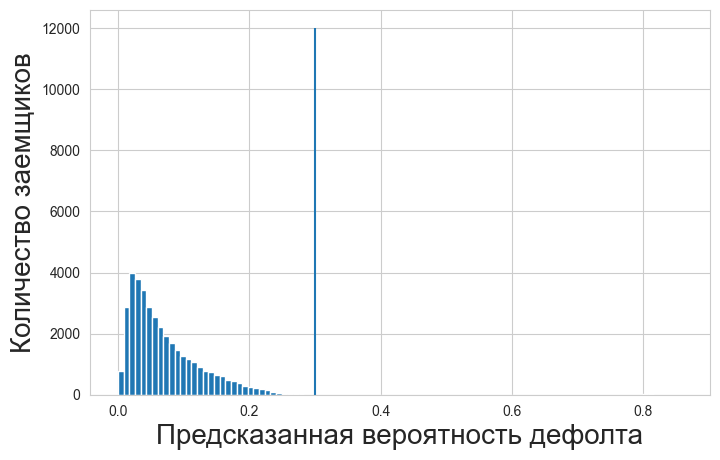

In [31]:
# Распределение предсказанной классификатором вероятности дефолта, метки 1
plt.figure(figsize=(8, 5))

plt.hist(test_probabilities, bins=100)
plt.vlines(0.3, 0, 12000)

plt.xlabel('Предсказанная вероятность дефолта', fontsize=20)
plt.ylabel('Количество заемщиков', fontsize=20)

---

### <center> _Порог классификатора_

In [32]:
# Список порогов
thresholds = [0.3, 0.5, 0.7]

# Создание матриц ошибок для каждого порога
confusion_matrices_lr = {}
confusion_matrices_rf = {}

# Логистическая регрессия
test_probabilities = logistic_regression_model.predict_proba(test_points)

for threshold in thresholds:
    predictions = (test_probabilities[:, 1] > threshold).astype(int)
    confusion_matrix_result = confusion_matrix(test_values, predictions)
    confusion_matrices_lr[threshold] = confusion_matrix_result

# Случайный лес
test_probabilities = random_forest_model.predict_proba(test_points)

for threshold in thresholds:
    predictions = (test_probabilities[:, 1] > threshold).astype(int)
    confusion_matrix_result = confusion_matrix(test_values, predictions)
    confusion_matrices_rf[threshold] = confusion_matrix_result

In [33]:
# Вывод матриц ошибок для каждого порога для модели логистической регрессии
print('Матрицы ошибок для модели логистической регрессии:')
for threshold in thresholds:
    confusion_matrix_result = confusion_matrices_lr[threshold]
    print(f"Порог: {threshold}")
    print(pd.DataFrame(confusion_matrix_result))
    print('\n')

# Вывод матриц ошибок для каждого порога для модели случайного леса
print('Матрицы ошибок для модели случайного леса:')
for threshold in thresholds:
    confusion_matrix_result = confusion_matrices_rf[threshold]
    print(f"Порог: {threshold}")
    print(pd.DataFrame(confusion_matrix_result))
    print('\n')

Матрицы ошибок для модели логистической регрессии:
Порог: 0.3
       0   1
0  34925  48
1   2483  44


Порог: 0.5
       0   1
0  34938  35
1   2498  29


Порог: 0.7
       0   1
0  34947  26
1   2508  19


Матрицы ошибок для модели случайного леса:
Порог: 0.3
       0     1
0  33585  1388
1   1534   993


Порог: 0.5
       0    1
0  34565  408
1   2039  488


Порог: 0.7
       0    1
0  34911   62
1   2400  127




---

### <center> _ROC кривая классификатора_

In [34]:
# Логистическая регрессия
test_probabilities_lr = logistic_regression_model.predict_proba(test_points)
test_probabilities_lr = test_probabilities_lr[:, 1]
# Получение координат точек ROC кривой
false_positive_rates_lr, true_positive_rates_lr, threshold_lr = roc_curve(test_values, test_probabilities_lr)

# Случайный лес
test_probabilities_rf = random_forest_model.predict_proba(test_points)
test_probabilities_rf = test_probabilities_rf[:, 1]
# Получение координат точек ROC кривой
false_positive_rates_rf, true_positive_rates_rf, threshold_rf = roc_curve(test_values, test_probabilities_rf)

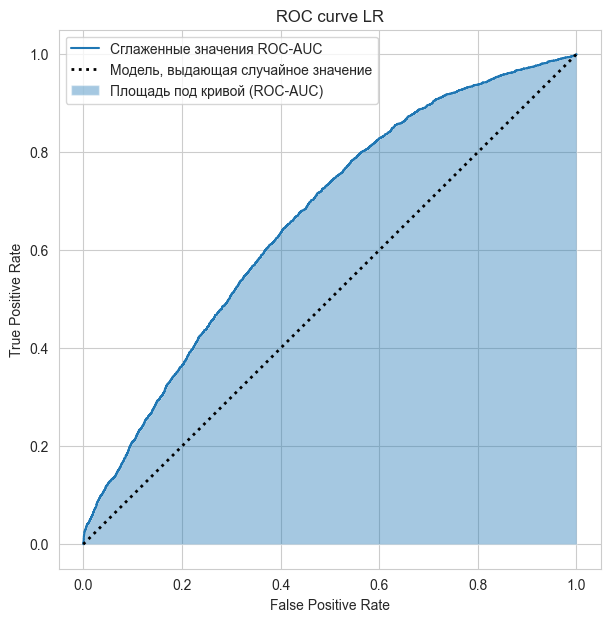

In [35]:
# Для модели логистической регрессии

# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates_lr, true_positive_rates_lr, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates_lr, true_positive_rates_lr, step="mid", alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

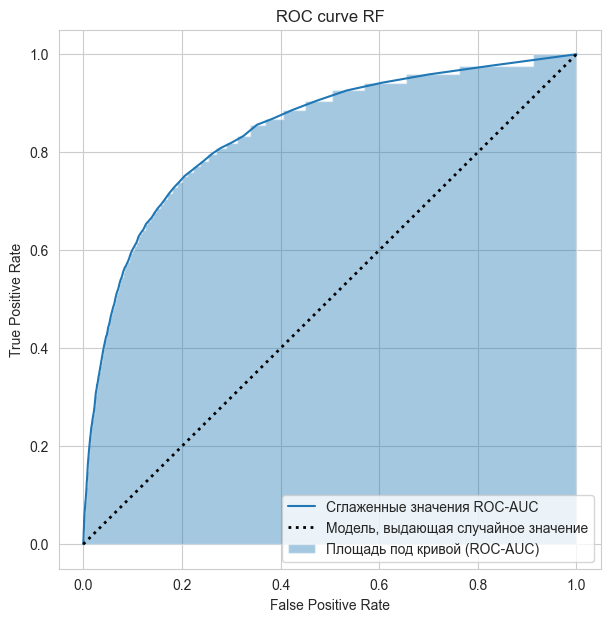

In [36]:
# Для модели случайного леса

# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates_rf, true_positive_rates_rf, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve RF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates_rf, true_positive_rates_rf, step="mid", alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [37]:
# Вычислите значения roc_auc_value для обеих моделей

# Для модели логистической регрессии
roc_auc_value_lr = roc_auc_score(test_values, test_probabilities_lr)
print("ROC-AUC на тестовой выборке для модели логистической регрессии:", round(roc_auc_value_lr, 4))

# Для модели случайного леса
roc_auc_value_rf = roc_auc_score(test_values, test_probabilities_rf)
print("ROC-AUC на тестовой выборке для модели случайного леса:", round(roc_auc_value_rf, 4))

ROC-AUC на тестовой выборке для модели логистической регрессии: 0.6618
ROC-AUC на тестовой выборке для модели случайного леса: 0.8436


---

In [38]:
!rm test_data.csv
!rm training_data.csv